## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [90]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 3. Модели
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgbm 
import catboost as catb

from sklearn.preprocessing import RobustScaler

In [91]:
import warnings
warnings.simplefilter('ignore')

In [92]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [93]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [94]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [95]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Пути к директориям и файлам**

In [96]:
# input
TRAIN_DATASET_PATH = 'C:/Users/vkhur/Desktop/Учеба/Библиотеки Python для Data Science/course_project_train.csv'
TEST_DATASET_PATH = 'C:/Users/vkhur/Desktop/Учеба/Библиотеки Python для Data Science/course_project_test.csv'

# output
PREP_DATASET_PATH = 'C:/Users/vkhur/Desktop/Учеба/Библиотеки Python для Data Science/VKhuranov_predictions.csv'

SCALER_FILE_PATH = 'C:/Users/vkhur/Desktop/Учеба/Библиотеки Python для Data Science/scaler.pkl'


# output
TRAIN_FULL_PATH = 'C:/Users/vkhur/Desktop/Учеба/Библиотеки Python для Data Science/training_project_train_full.csv'
TRAIN_PART_PATH = 'C:/Users/vkhur/Desktop/Учеба/Библиотеки Python для Data Science/training_project_train_part_b.csv'
TEST_PART_PATH = 'C:/Users/vkhur/Desktop/Учеба/Библиотеки Python для Data Science/training_project_test_part.csv'

**Загрузка данных**

In [97]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [98]:
df_test = pd.read_csv(TRAIN_DATASET_PATH)
df_test.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


### Анализ и обработка данных 

In [100]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

#### Обзор номинативных признаков

In [101]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

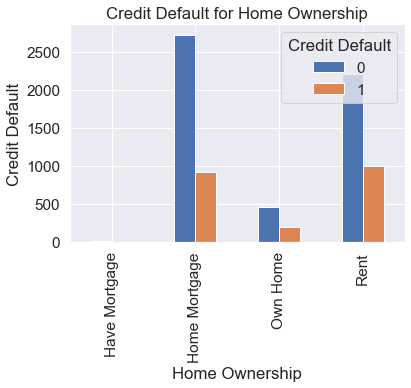

In [102]:
%matplotlib inline
pd.crosstab(df['Home Ownership'],df['Credit Default']).plot(kind='bar')
plt.title('Credit Default for Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Credit Default')
plt.savefig('Credit Default for Home Ownership')

In [103]:
# преобразую признак в числовой, совмещяю Have Mortgage с Home Mortgage, так как являеться одним признаком
df['Home Ownerships'] = df['Home Ownership'].map({'Home Mortgage':'1', "Have Mortgage":'1', 'Own Home':'2', 'Rent':'3' }).astype(int)

# Удаляю столбец дублирующий Home Ownerships
df.drop(columns='Home Ownership', inplace=True) 

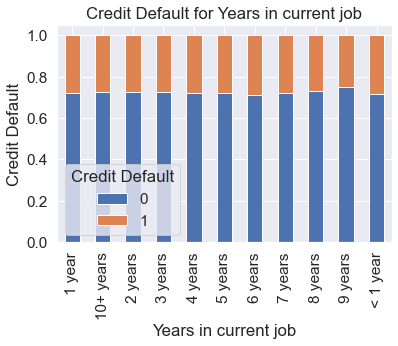

In [104]:
table=pd.crosstab(df['Years in current job'],df['Credit Default'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Credit Default for Years in current job')
plt.xlabel('Years in current job')
plt.ylabel('Credit Default')
plt.savefig('Credit Default for Years in current job')

In [105]:
# Заменяю пропуски на моду
df[['Years in current job']] = df[['Years in current job']]. fillna('nan')
df.loc[df['Years in current job'] == 'nan', 'Years in current job'] = df['Years in current job'].mode()[0]

# преобразую признак в числовой
df['Years in current jobs'] = df['Years in current job'].map({'< 1 year':'0', '1 year':'1', '2 years':'2', '3 years':'3', '4 years':'4', '5 years':'5', '6 years':'6', '7 years':'7', '8 years':'8', '9 years':'9', '10+ years':'10' }).astype(float)
df['Years in current jobs'] = df['Years in current jobs'].astype(int)

# Удаляю столбец дублирующий Years in current jobs
df.drop(columns='Years in current job', inplace=True) 

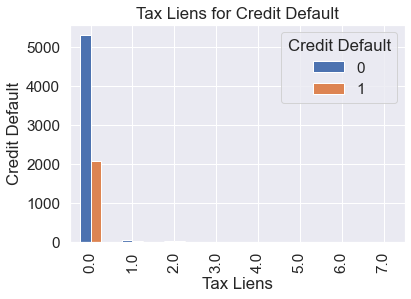

In [106]:
pd.crosstab(df['Tax Liens'],df['Credit Default']).plot(kind='bar')
plt.title('Tax Liens for Credit Default')
plt.xlabel('Tax Liens')
plt.ylabel('Credit Default')
plt.savefig('Tax Liens for Credit Default')

In [107]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [108]:
# Преобразую в целочисленное
df['Tax Liens'] = df['Tax Liens'].astype(int)

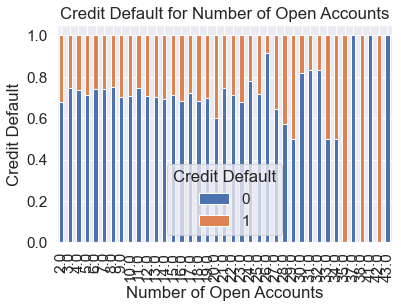

In [109]:
table=pd.crosstab(df['Number of Open Accounts'],df['Credit Default'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Credit Default for Number of Open Accounts')
plt.xlabel('Number of Open Accounts')
plt.ylabel('Credit Default')
plt.savefig('Credit Default for Number of Open Accounts')

In [110]:
df['Number of Open Accounts'].sort_values().unique()

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 37., 38., 41., 42., 43.])

In [111]:
# Преобразую в целочисленное
df['Number of Open Accounts'] = df['Number of Open Accounts'].astype(int)

In [112]:
df['Years of Credit History'].sort_values().unique()

array([ 4. ,  4.3,  4.5,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3,
       15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16. , 16.1, 16.2, 16.3, 16.4,
       16.5, 16.6, 16.7, 16.8, 16.9, 17. , 17.1, 17.2, 17.3, 17.4, 17.5,
       17.6, 17.7, 17.8, 17.9, 18. , 18.1, 18.2, 18.3, 18.4, 18.5, 18.6,
       18.7, 18.8, 18.9, 19. , 19.1, 19.2, 19.3, 19

In [113]:
# Заменяю признак на 6 категории 

df.loc[df['Years of Credit History'] <= 10.0  , 'Years of Credit History'] = 1

df.loc[df['Years of Credit History'] > 50.1 , 'Years of Credit History'] = 6
df.loc[df['Years of Credit History'] > 40.1 , 'Years of Credit History'] = 5
df.loc[df['Years of Credit History'] > 30.1 , 'Years of Credit History'] = 4
df.loc[df['Years of Credit History'] > 20.1 , 'Years of Credit History'] = 3
df.loc[df['Years of Credit History'] >= 10.1 , 'Years of Credit History'] = 2

df['Years of Credit History'] = df['Years of Credit History'].astype(int)

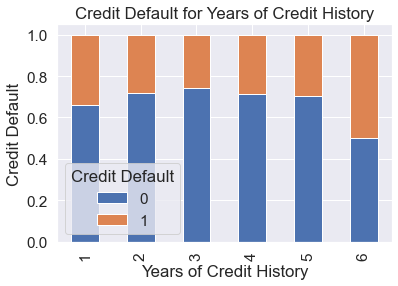

In [114]:
table=pd.crosstab(df['Years of Credit History'],df['Credit Default'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Credit Default for Years of Credit History')
plt.xlabel('Years of Credit History')
plt.ylabel('Credit Default')
plt.savefig('Credit Default for Years of Credit History')

In [115]:
df['Number of Credit Problems'].sort_values().unique()

array([0., 1., 2., 3., 4., 5., 6., 7.])

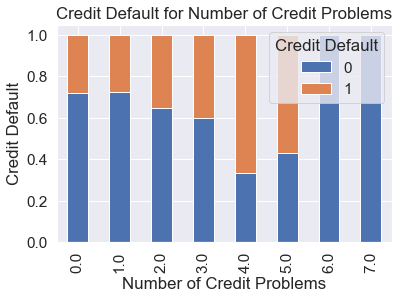

In [116]:
table=pd.crosstab(df['Number of Credit Problems'],df['Credit Default'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Credit Default for Number of Credit Problems')
plt.xlabel('Number of Credit Problems')
plt.ylabel('Credit Default')
plt.savefig('Credit Default for Number of Credit Problems')

На графике видно что признак можно обьеденить в 4 категории

In [117]:
# Заменяю признак на 4 категории 

df.loc[df['Number of Credit Problems'] == 0.0 , 'Number of Credit Problems'] = 1.0
df.loc[df['Number of Credit Problems'] == 3.0 , 'Number of Credit Problems'] = 2.0
df.loc[df['Number of Credit Problems'] == 4.0 , 'Number of Credit Problems'] = 3.0
df.loc[df['Number of Credit Problems'] == 5.0 , 'Number of Credit Problems'] = 3.0
df.loc[df['Number of Credit Problems'] == 6.0 , 'Number of Credit Problems'] = 4.0
df.loc[df['Number of Credit Problems'] == 7.0 , 'Number of Credit Problems'] = 4.0

# Преобразую в целочисленное
df['Number of Credit Problems'] = df['Number of Credit Problems'].astype(int)

In [118]:
df['Months since last delinquent'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  86.,  91.,  92.,
       118.,  nan])

In [119]:
# Заменяю пропуски на 0
df[['Months since last delinquent']] = df[['Months since last delinquent']].fillna(0)

# Преобразую в целочисленное
df['Months since last delinquent'] = df['Months since last delinquent'].astype(int)

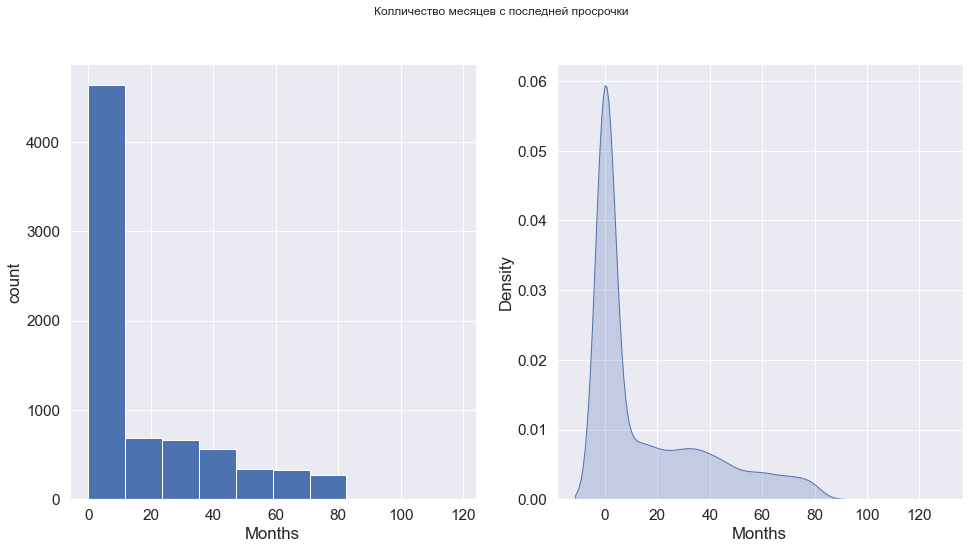

In [120]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Months since last delinquent'].hist()
plt.ylabel('count')
plt.xlabel('Months')

plt.subplot(122)
sns.kdeplot(df['Months since last delinquent'], shade=True, legend=False)
plt.xlabel('Months')

plt.suptitle('Колличество месяцев с последней просрочки')
plt.show()

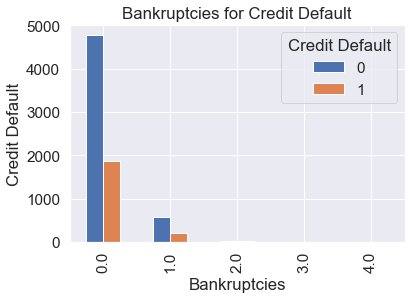

In [121]:
pd.crosstab(df['Bankruptcies'],df['Credit Default']).plot(kind='bar')
plt.title('Bankruptcies for Credit Default')
plt.xlabel('Bankruptcies')
plt.ylabel('Credit Default')
plt.savefig('Bankruptcies for Credit Default')

In [122]:
df['Bankruptcies'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4., nan])

In [123]:
# Заменяю пропуски на моду
df[['Bankruptcies']] = df[['Bankruptcies']]. fillna('nan')
df.loc[df['Bankruptcies'] == 'nan', 'Bankruptcies'] = df['Bankruptcies'].mode()[0]

# Преобразую в целочисленное
df['Bankruptcies'] = df['Bankruptcies'].astype(int)

In [124]:
df['Term'].sort_values().unique()

array(['Long Term', 'Short Term'], dtype=object)

In [125]:
# преобразую в бинарный признак
df['Terms'] = df['Term'].map({'Long Term':'1', "Short Term":'0'}).astype(int)

# Удаляю дублирующий столбец Terms
df.drop(columns='Term', inplace=True) 

In [126]:
df['Credit Score'].sort_values().unique()

array([ 585.,  586.,  588.,  589.,  590.,  591.,  593.,  594.,  597.,
        598.,  599.,  601.,  602.,  604.,  606.,  607.,  608.,  609.,
        610.,  611.,  612.,  613.,  614.,  615.,  616.,  617.,  618.,
        619.,  620.,  621.,  622.,  624.,  625.,  626.,  627.,  628.,
        629.,  630.,  631.,  632.,  633.,  634.,  635.,  636.,  637.,
        638.,  639.,  640.,  642.,  643.,  644.,  645.,  646.,  647.,
        648.,  649.,  650.,  651.,  652.,  653.,  654.,  655.,  656.,
        657.,  658.,  659.,  660.,  661.,  662.,  663.,  664.,  665.,
        666.,  667.,  668.,  669.,  670.,  671.,  672.,  673.,  674.,
        675.,  676.,  677.,  678.,  679.,  680.,  681.,  682.,  683.,
        684.,  685.,  686.,  687.,  688.,  689.,  690.,  691.,  692.,
        693.,  694.,  695.,  696.,  697.,  698.,  699.,  700.,  701.,
        702.,  703.,  704.,  705.,  706.,  707.,  708.,  709.,  710.,
        711.,  712.,  713.,  714.,  715.,  716.,  717.,  718.,  719.,
        720.,  721.,

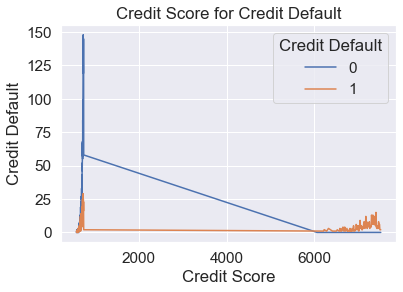

In [127]:
pd.crosstab(df['Credit Score'],df['Credit Default']).plot()
plt.title('Credit Score for Credit Default')
plt.xlabel('Credit Score')
plt.ylabel('Credit Default')
plt.savefig('Credit Score for Credit Default')

In [128]:
# Заменяю признак на 3 категории : 0 - пропуски, 1- от 400 до 800, 2 - от 4000 и выше
df[['Credit Score']] = df[['Credit Score']]. fillna(0.0)
df.loc[df['Credit Score'] > 4000.0  , 'Credit Score'] = 2.0
df.loc[df['Credit Score'] > 400.0  , 'Credit Score'] = 1.0
df['Credit Score'] = df['Credit Score'].astype(int)

In [129]:
df['Purpose'].sort_values().unique()

array(['business loan', 'buy a car', 'buy house', 'debt consolidation',
       'educational expenses', 'home improvements', 'major purchase',
       'medical bills', 'moving', 'other', 'renewable energy',
       'small business', 'take a trip', 'vacation', 'wedding'],
      dtype=object)

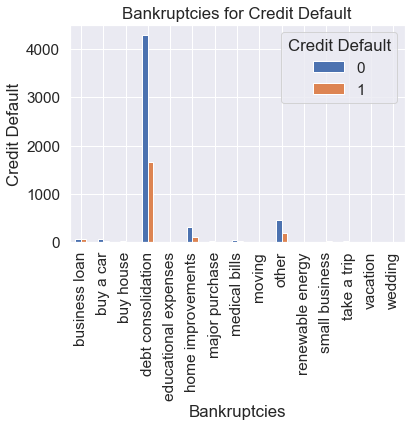

In [130]:
pd.crosstab(df['Purpose'],df['Credit Default']).plot(kind='bar')
plt.title('Bankruptcies for Credit Default')
plt.xlabel('Bankruptcies')
plt.ylabel('Credit Default')
plt.savefig('Bankruptcies for Credit Default')

In [131]:
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [132]:
# Преобразую оставшийся категориальный признак на числовой
df = pd.get_dummies(df) 

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 5943 non-null   float64
 1   Tax Liens                     7500 non-null   int32  
 2   Number of Open Accounts       7500 non-null   int32  
 3   Years of Credit History       7500 non-null   int32  
 4   Maximum Open Credit           7500 non-null   float64
 5   Number of Credit Problems     7500 non-null   int32  
 6   Months since last delinquent  7500 non-null   int32  
 7   Bankruptcies                  7500 non-null   int32  
 8   Current Loan Amount           7500 non-null   float64
 9   Current Credit Balance        7500 non-null   float64
 10  Monthly Debt                  7500 non-null   float64
 11  Credit Score                  7500 non-null   int32  
 12  Credit Default                7500 non-null   int64  
 13  Hom

#### Обзор количественных признаков

In [134]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,2.315867e+00,7.581809e-01,1.0,2.0,2.0,3.00,6.000000e+00
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.023333e+00,1.762376e-01,1.0,1.0,1.0,1.00,4.000000e+00
Months since last delinquent,7500.0,1.581520e+01,2.264944e+01,0.0,0.0,0.0,29.00,1.180000e+02
Bankruptcies,7500.0,1.169333e-01,3.469044e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


In [135]:
df.groupby(TARGET_NAME).mean()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
Credit Default,,,,,,,,,,,,,,,,,,,,,
0,1.418047e+06,0.025988,11.042138,2.329126,1.088422e+06,1.020048,15.671802,0.116577,1.640219e+07,293719.423427,...,0.056432,0.005755,0.009096,0.001671,0.086876,0.000000,0.002228,0.005012,0.001114,0.002042
1,1.224243e+06,0.040700,11.357312,2.282063,5.798982e+05,1.031708,16.180786,0.117842,3.266510e+05,279925.570279,...,0.051112,0.004259,0.010412,0.000947,0.093232,0.000947,0.006626,0.004733,0.000947,0.001893


In [136]:
# Заменяю пропуски на медиану
median = df['Annual Income'].median()
df['Annual Income'].fillna(median, inplace=True)

In [137]:
# Заменяю признак на 5 категории 

df.loc[df['Annual Income'] > 2000000.0  , 'Annual Income'] = 5.0
df.loc[df['Annual Income'] > 1500000.0  , 'Annual Income'] = 4.0
df.loc[df['Annual Income'] > 1000000.0  , 'Annual Income'] = 3.0
df.loc[df['Annual Income'] > 500000.0  , 'Annual Income'] = 2.0
df.loc[df['Annual Income'] > 5.0  , 'Annual Income'] = 1.0
df['Annual Income'] = df['Annual Income'].astype(int)

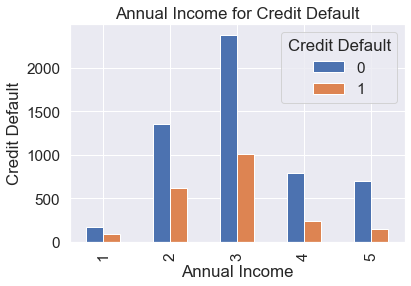

In [138]:
pd.crosstab(df['Annual Income'],df['Credit Default']).plot(kind='bar')
plt.title('Annual Income for Credit Default')
plt.xlabel('Annual Income')
plt.ylabel('Credit Default')
plt.savefig('Annual Income for Credit Default')

<AxesSubplot:xlabel='Current Loan Amount'>

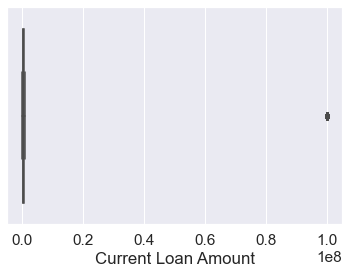

In [139]:
sns.boxplot(x=df['Current Loan Amount'])

In [140]:
# Заменяю выбросы на медиану
median = df['Current Loan Amount'].median()
df.loc[(df['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median

<AxesSubplot:xlabel='Current Credit Balance'>

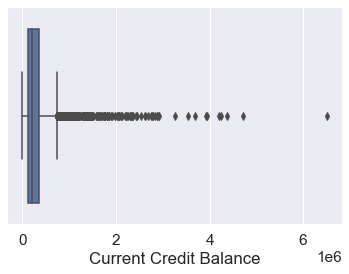

In [141]:
sns.boxplot(x=df['Current Credit Balance'])

In [142]:
Square_max_value = np.quantile(df['Current Credit Balance'], q=0.975)
condition = (df['Current Credit Balance'] > Square_max_value) # Заменяю выбросы с помощью квантилей на медиану
df.loc[condition, 'Current Credit Balance'] = df['Current Credit Balance'].median()
df['Current Credit Balance'].describe()

count      7500.000000
mean     253853.826933
std      193851.459239
min           0.000000
25%      114256.500000
50%      209313.500000
75%      338314.000000
max      997899.000000
Name: Current Credit Balance, dtype: float64

### Построение новых признаков<a class="anchor" id="new_features"></a>

In [143]:
df['ID'] = df.index.tolist()

#### Обзор целевой переменной

In [144]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

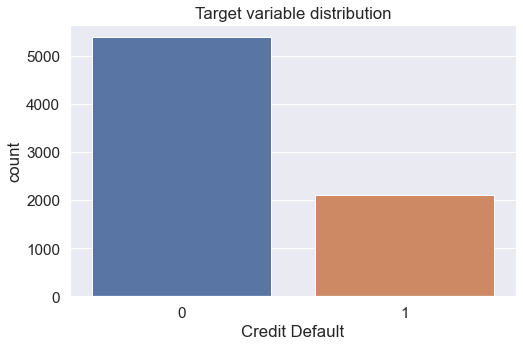

In [145]:
plt.figure(figsize=(8, 5))

sns.countplot(x='Credit Default', data=df)

plt.title('Target variable distribution')
plt.show()

На графике виден явный дисбаланс классов целевой переменной

#### Корреляция с базовыми признаками

In [146]:
BASE_FEATURE_NAMES = df.columns.drop('Credit Default').tolist()
NEW_FEATURE_NAMES = df.columns.drop(['Credit Default'] + BASE_FEATURE_NAMES)

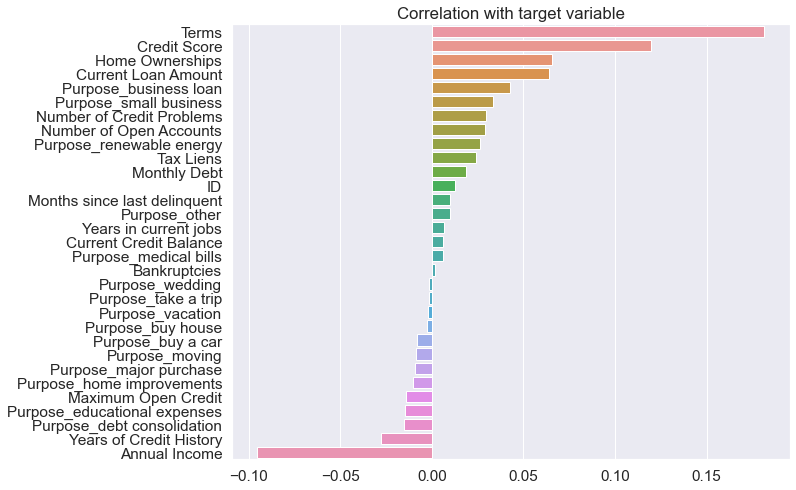

In [147]:
corr_with_target = df[BASE_FEATURE_NAMES + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

#### Матрица корреляций

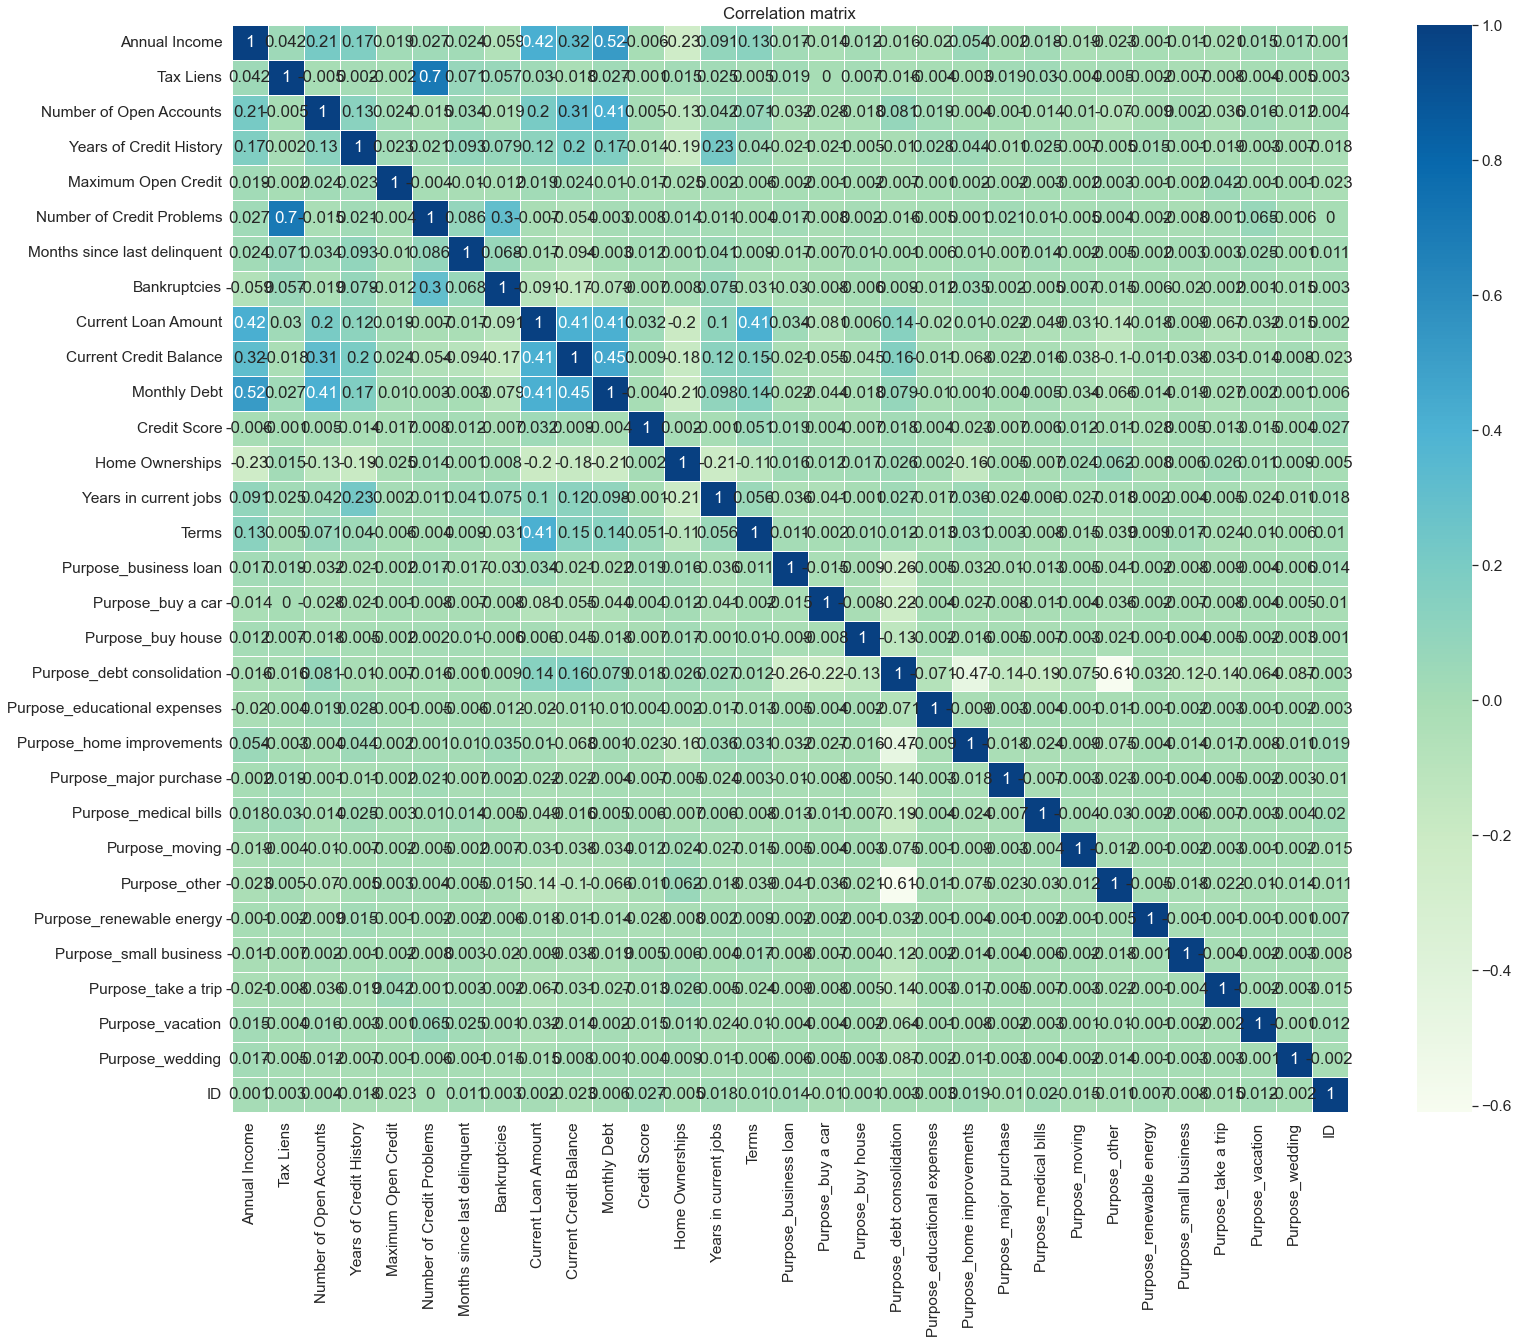

In [148]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

#### Выделение целевой переменной и групп признаков

In [150]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME, 'ID'] + BASE_FEATURE_NAMES).tolist()

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [151]:
df.columns.tolist()

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Home Ownerships',
 'Years in current jobs',
 'Terms',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
 'ID']

In [152]:
NUM_FEATURE_NAMES = ['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownerships',
 'Years in current jobs',
 'Terms',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',]


SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES


#### Нормализация данных

In [153]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

**Сохранение модели для нормализации данных**

In [154]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [155]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [156]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [157]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a> 

In [158]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [159]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка модели<a class="anchor" id="baseline_modeling"></a> 

In [177]:
%%time
final_model = catb.CatBoostClassifier(n_estimators=150, max_depth=5,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.91      0.85      3771
           1       0.86      0.72      0.78      2958

    accuracy                           0.82      6729
   macro avg       0.83      0.81      0.82      6729
weighted avg       0.83      0.82      0.82      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1616
           1       0.54      0.51      0.52       634

    accuracy                           0.74      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.73      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1341  275
1                313  321
CPU times: total: 3.52 s
Wall time: 875 ms


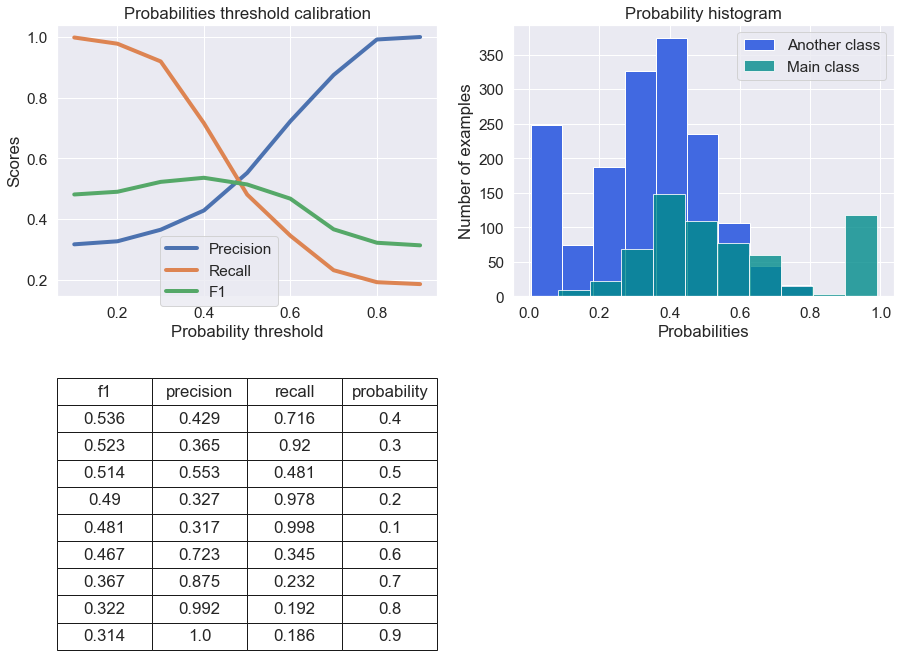

In [178]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

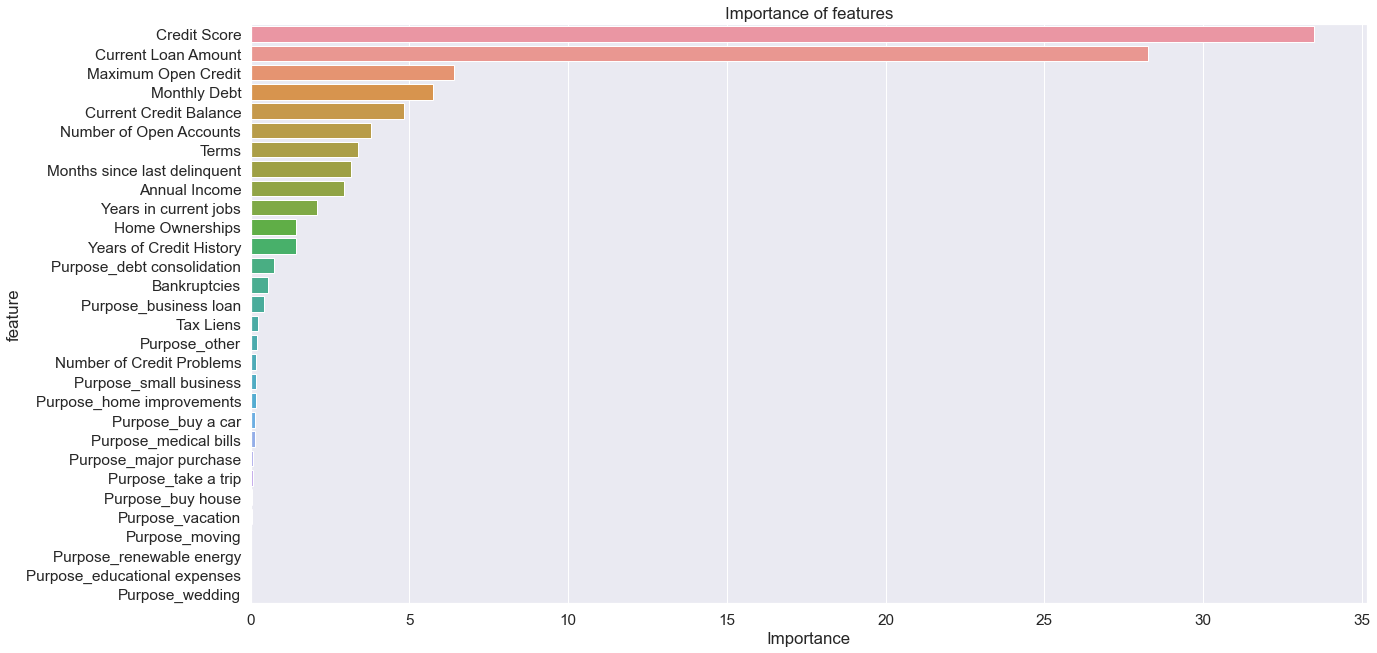

In [179]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=20)

In [180]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Terms',
 'Months since last delinquent',
 'Annual Income',
 'Years in current jobs',
 'Home Ownerships',
 'Years of Credit History',
 'Purpose_debt consolidation',
 'Bankruptcies',
 'Purpose_business loan',
 'Tax Liens',
 'Purpose_other',
 'Number of Credit Problems',
 'Purpose_small business',
 'Purpose_home improvements']

In [182]:
final_model = catb.CatBoostClassifier(n_estimators=150, max_depth=5,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      3771
           1       0.87      0.72      0.79      2958

    accuracy                           0.83      6729
   macro avg       0.84      0.82      0.82      6729
weighted avg       0.83      0.83      0.83      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1616
           1       0.55      0.51      0.53       634

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1354  262
1                312  322


#### Подготовка тестового датасета

In [183]:
# преобразую признак в числовой, совмещяю Have Mortgage с Home Mortgage, так как являеться одним признаком
df_test['Home Ownerships'] = df_test['Home Ownership'].map({'Home Mortgage':'1', "Have Mortgage":'1', 'Own Home':'2', 'Rent':'3' }).astype(int)

# Удаляю столбец дублирующий Home Ownerships
df_test.drop(columns='Home Ownership', inplace=True) 

# Заменяю пропуски на моду
df_test[['Years in current job']] = df_test[['Years in current job']]. fillna('nan')
df_test.loc[df_test['Years in current job'] == 'nan', 'Years in current job'] = df_test['Years in current job'].mode()[0]

# преобразую признак в числовой
df_test['Years in current jobs'] = df_test['Years in current job'].map({'< 1 year':'0', '1 year':'1', '2 years':'2', '3 years':'3', '4 years':'4', '5 years':'5', '6 years':'6', '7 years':'7', '8 years':'8', '9 years':'9', '10+ years':'10' }).astype(float)
df_test['Years in current jobs'] = df_test['Years in current jobs'].astype(int)

# Удаляю столбец дублирующий Years in current jobs
df_test.drop(columns='Years in current job', inplace=True) 

# Преобразую в целочисленное
df_test['Tax Liens'] = df_test['Tax Liens'].astype(int)
df_test['Number of Open Accounts'] = df_test['Number of Open Accounts'].astype(int)

# Заменяю признак на 6 категории 

df_test.loc[df_test['Years of Credit History'] <= 10.0  , 'Years of Credit History'] = 1

df_test.loc[df_test['Years of Credit History'] > 50.1 , 'Years of Credit History'] = 6
df_test.loc[df_test['Years of Credit History'] > 40.1 , 'Years of Credit History'] = 5
df_test.loc[df_test['Years of Credit History'] > 30.1 , 'Years of Credit History'] = 4
df_test.loc[df_test['Years of Credit History'] > 20.1 , 'Years of Credit History'] = 3
df_test.loc[df_test['Years of Credit History'] >= 10.1 , 'Years of Credit History'] = 2


# Преобразую в целочисленное
df_test['Years of Credit History'] = df_test['Years of Credit History'].astype(int)

# Заменяю признак на 4 категории 

df_test.loc[df_test['Number of Credit Problems'] == 0.0 , 'Number of Credit Problems'] = 1.0
df_test.loc[df_test['Number of Credit Problems'] == 3.0 , 'Number of Credit Problems'] = 2.0
df_test.loc[df_test['Number of Credit Problems'] == 4.0 , 'Number of Credit Problems'] = 3.0
df_test.loc[df_test['Number of Credit Problems'] == 5.0 , 'Number of Credit Problems'] = 3.0
df_test.loc[df_test['Number of Credit Problems'] == 6.0 , 'Number of Credit Problems'] = 4.0
df_test.loc[df_test['Number of Credit Problems'] == 7.0 , 'Number of Credit Problems'] = 4.0

# Преобразую в целочисленное
df_test['Number of Credit Problems'] = df_test['Number of Credit Problems'].astype(int)

# Заменяю пропуски на 0
df_test[['Months since last delinquent']] = df_test[['Months since last delinquent']].fillna(0)

# Преобразую в целочисленное
df_test['Months since last delinquent'] = df_test['Months since last delinquent'].astype(int)

# Заменяю пропуски на моду
df_test[['Bankruptcies']] = df_test[['Bankruptcies']]. fillna('nan')
df_test.loc[df_test['Bankruptcies'] == 'nan', 'Bankruptcies'] = df_test['Bankruptcies'].mode()[0]

# Преобразую в целочисленное
df_test['Bankruptcies'] = df_test['Bankruptcies'].astype(int)

# преобразую в бинарный признак
df_test['Terms'] = df_test['Term'].map({'Long Term':'1', "Short Term":'0'}).astype(int)

# Удаляю дублирующий столбец Terms
df_test.drop(columns='Term', inplace=True) 

# Заменяю признак на 3 категории : 0 - пропуски, 1- от 400 до 800, 2 - от 4000 и выше
df_test[['Credit Score']] = df_test[['Credit Score']]. fillna(0.0)
df_test.loc[df_test['Credit Score'] > 4000.0  , 'Credit Score'] = 2.0
df_test.loc[df_test['Credit Score'] > 400.0  , 'Credit Score'] = 1.0
df_test['Credit Score'] = df_test['Credit Score'].astype(int)

# Преобразую оставшийся категориальный признак на числовой
df_test = pd.get_dummies(df_test) 

# Заменяю пропуски на медиану
median = df_test['Annual Income'].median()
df_test['Annual Income'].fillna(median, inplace=True)

# Заменяю признак на 5 категории 

df_test.loc[df_test['Annual Income'] > 2000000.0  , 'Annual Income'] = 5.0
df_test.loc[df_test['Annual Income'] > 1500000.0  , 'Annual Income'] = 4.0
df_test.loc[df_test['Annual Income'] > 1000000.0  , 'Annual Income'] = 3.0
df_test.loc[df_test['Annual Income'] > 500000.0  , 'Annual Income'] = 2.0
df_test.loc[df_test['Annual Income'] > 5.0  , 'Annual Income'] = 1.0

# Преобразую в целочисленное
df_test['Annual Income'] = df_test['Annual Income'].astype(int)

# Заменяю выбросы на медиану
median = df_test['Current Loan Amount'].median()
df_test.loc[(df_test['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median

Square_max_value = np.quantile(df_test['Current Credit Balance'], q=0.975)
condition = (df_test['Current Credit Balance'] > Square_max_value) # Заменяю выбросы с помощью квантилей на медиану
df_test.loc[condition, 'Current Credit Balance'] = df_test['Current Credit Balance'].median()

df_test['ID'] = df_test.index.tolist()

In [184]:
df_for_model = df_test[SELECTED_FEATURE_NAMES]
df_for_model.head(10)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,1,0,11,3,685960.0,1,0,1,309573.0,47386.0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,15,2,1181730.0,1,0,0,264968.0,394972.0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,11,4,1182434.0,1,0,0,309573.0,308389.0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,8,3,147400.0,1,0,1,121396.0,95855.0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,13,2,385836.0,1,0,0,125840.0,93309.0,...,0,0,0,0,0,0,0,0,0,0
5,3,0,12,2,366784.0,1,0,0,337304.0,165680.0,...,0,0,0,0,1,0,0,0,0,0
6,4,0,9,3,388124.0,1,73,0,309573.0,51623.0,...,1,0,0,0,0,0,0,0,0,0
7,3,0,13,2,330374.0,1,18,0,250888.0,89015.0,...,0,0,0,0,1,0,0,0,0,0
8,3,0,17,2,0.0,1,0,1,129734.0,19.0,...,1,0,0,0,0,0,0,0,0,0
9,3,0,10,3,511302.0,1,6,0,572880.0,205333.0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
y_pred_output = final_model.predict(df_for_model)
y_pred_output.shape

(7500,)

In [190]:
result = pd.DataFrame({'ID': df_test['ID'], 'Credit Default': y_pred_output})

In [191]:
result['Credit Default'].value_counts()

0    6262
1    1238
Name: Credit Default, dtype: int64

In [192]:
result.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

In [194]:
SAMPLE = PREP_DATASET_PATH
df_sample = pd.read_csv(SAMPLE)

predictions = pd.DataFrame(index = df_sample['ID'])

predictions[TARGET_NAME] = y_pred_output
predictions

,Credit Default
ID,
0,0
1,0
2,0
3,0
4,0
...,...
7495,0
7496,1
7497,0
